In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib

sns.set(style =  "whitegrid")

In [3]:
df = pd.read_csv('House_Price.csv')

In [4]:
df

,bedrooms,house_size,floor,city,price
0,4.0,1425.0,3.0,Bengaluru,503877
1,5.0,2947.0,1.0,NaN,684538
2,3.0,2305.0,1.0,Bengaluru,590479
3,5.0,1469.0,1.0,Gurugram,508561
4,5.0,1594.0,1.0,Bengaluru,595891
...,...,...,...,...,...
4995,NaN,2275.0,3.0,Noida,463621
4996,4.0,2760.0,1.0,Bengaluru,775568
4997,5.0,935.0,2.0,Gurugram,408619
4998,4.0,1351.0,1.0,NaN,319547


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bedrooms    4750 non-null   float64
 1   house_size  4750 non-null   float64
 2   floor       4750 non-null   float64
 3   city        4750 non-null   object 
 4   price       5000 non-null   int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 195.4+ KB


In [7]:
df.describe()

,bedrooms,house_size,floor,price
count,4750.000000,4750.000000,4750.000000,5.000000e+03
mean,3.004421,2244.821263,1.984211,5.114221e+05
std,1.425256,1013.665441,0.822127,1.965241e+05
min,1.000000,501.000000,1.000000,8.104700e+04
25%,2.000000,1371.000000,1.000000,3.620255e+05
50%,3.000000,2224.000000,2.000000,4.866230e+05
75%,4.000000,3136.000000,3.000000,6.451470e+05
max,5.000000,3999.000000,3.000000,1.080663e+06


In [8]:
df.isnull().sum()

bedrooms      250
house_size    250
floor         250
city          250
price           0
dtype: int64

In [13]:
len(df.dropna())/len(df)*100

81.64

In [14]:
df = df.dropna()

In [15]:
df

,bedrooms,house_size,floor,city,price
0,4.0,1425.0,3.0,Bengaluru,503877
2,3.0,2305.0,1.0,Bengaluru,590479
3,5.0,1469.0,1.0,Gurugram,508561
4,5.0,1594.0,1.0,Bengaluru,595891
5,2.0,2528.0,1.0,Bengaluru,569929
...,...,...,...,...,...
4993,5.0,3487.0,3.0,Bengaluru,956582
4994,2.0,1059.0,2.0,Bengaluru,320150
4996,4.0,2760.0,1.0,Bengaluru,775568
4997,5.0,935.0,2.0,Gurugram,408619


In [17]:
df['city'].unique()

array(['Bengaluru', 'Gurugram', 'Noida'], dtype=object)

# EDA

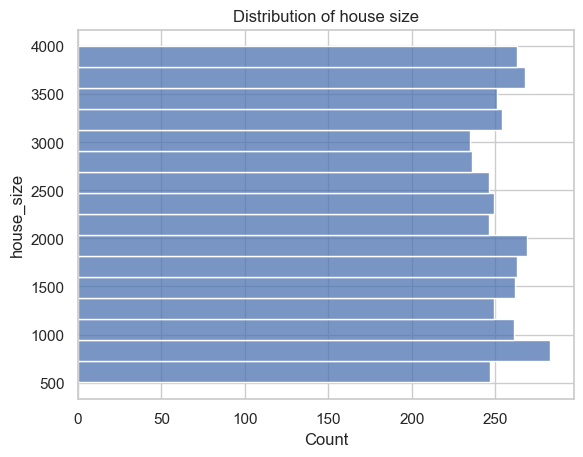

In [22]:
plt.title("Distribution of house size")
sns.histplot(data=df, y='house_size')
plt.show()

In [23]:
df.head()

,bedrooms,house_size,floor,city,price
0,4.0,1425.0,3.0,Bengaluru,503877
2,3.0,2305.0,1.0,Bengaluru,590479
3,5.0,1469.0,1.0,Gurugram,508561
4,5.0,1594.0,1.0,Bengaluru,595891
5,2.0,2528.0,1.0,Bengaluru,569929


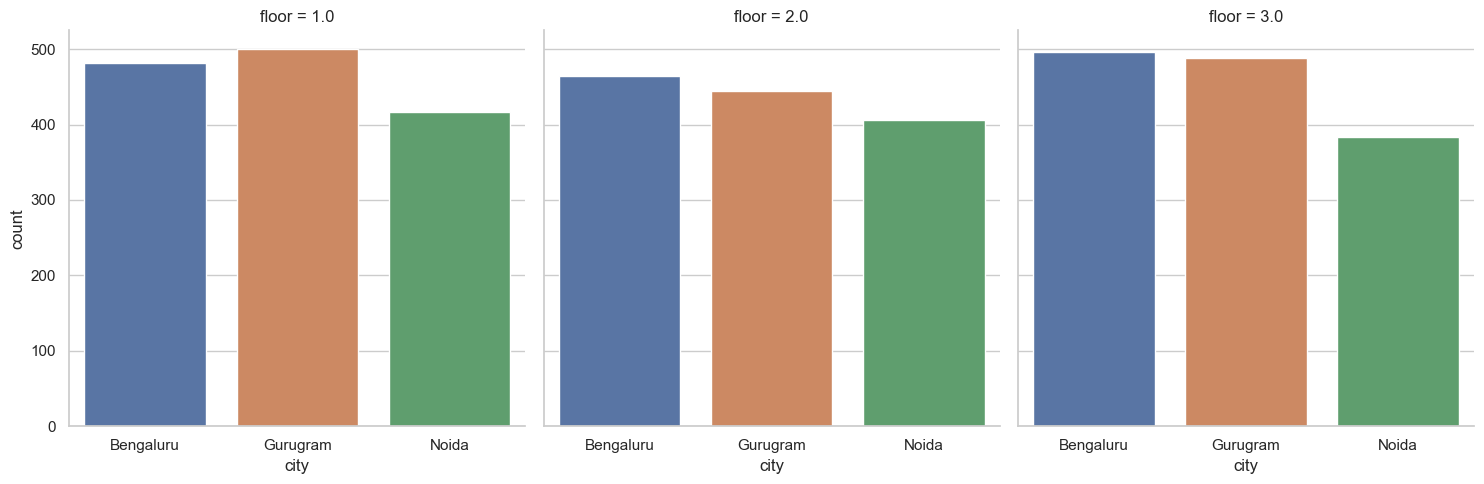

In [29]:
count_df = df.groupby(['floor', 'city']).size().reset_index(name='count')
sns.catplot(data=count_df, x='city', y='count', col='floor', kind='bar', hue='city')

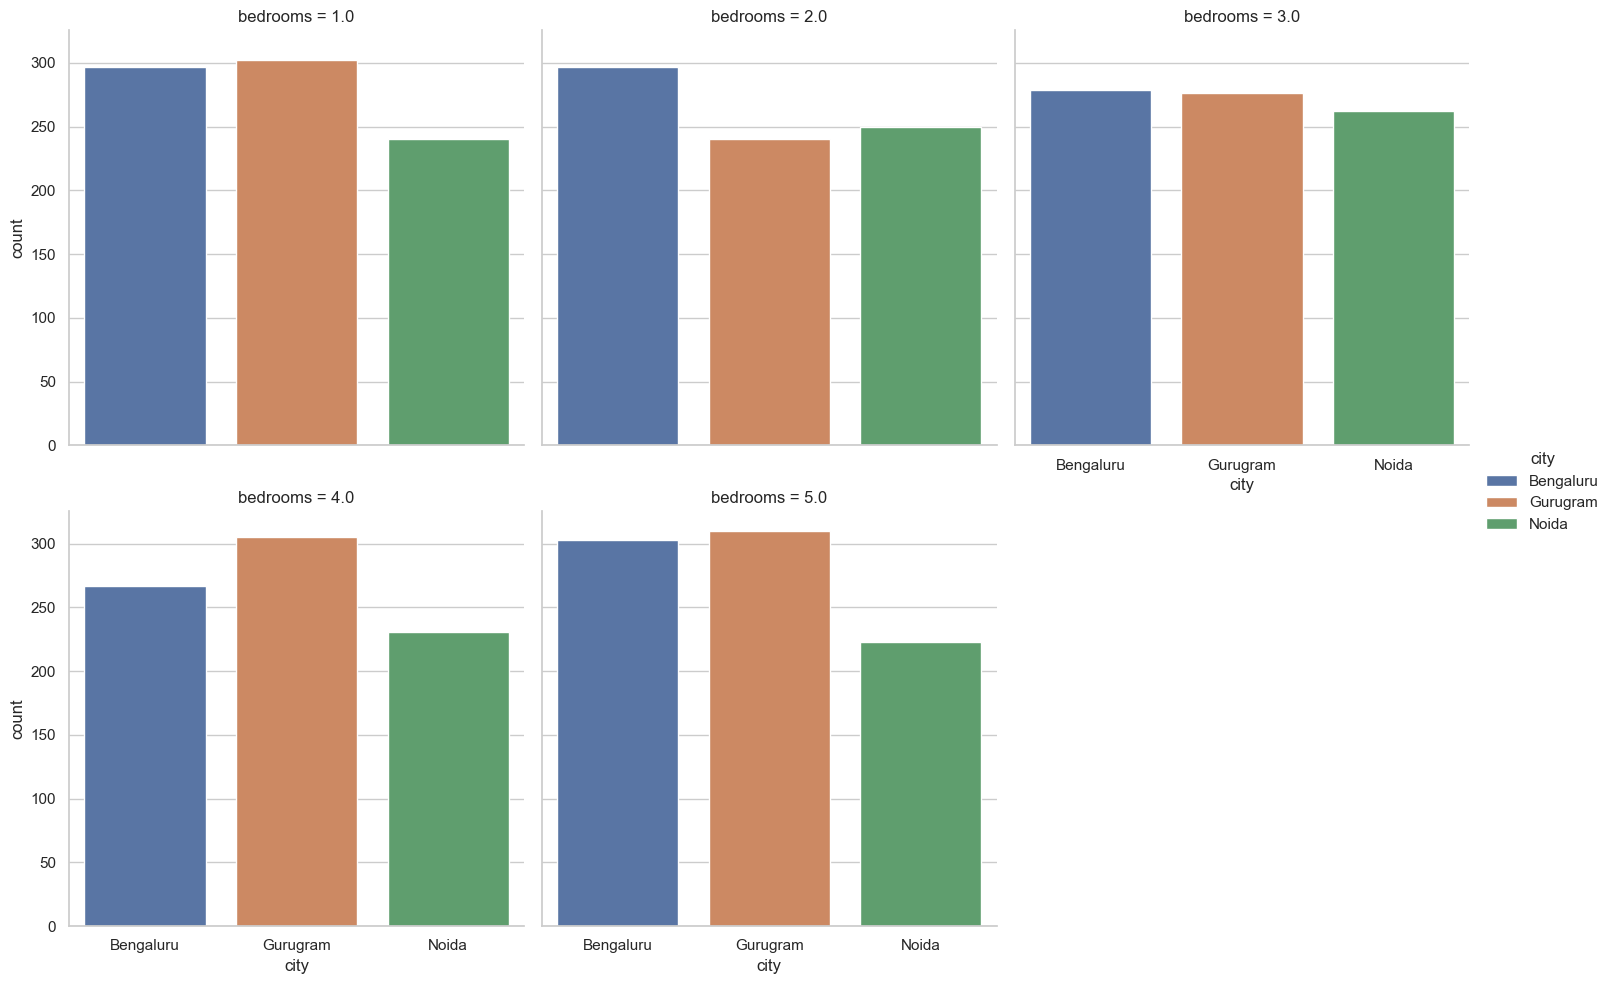

In [44]:
count_df2 = df.groupby(['bedrooms', 'city']).size().reset_index(name='count')
sns.catplot(data=count_df2, x='city', y='count', col='bedrooms', kind='bar', hue='city', col_wrap=3, height=5, legend=True)
plt.show()

In [45]:
df

,bedrooms,house_size,floor,city,price
0,4.0,1425.0,3.0,Bengaluru,503877
2,3.0,2305.0,1.0,Bengaluru,590479
3,5.0,1469.0,1.0,Gurugram,508561
4,5.0,1594.0,1.0,Bengaluru,595891
5,2.0,2528.0,1.0,Bengaluru,569929
...,...,...,...,...,...
4993,5.0,3487.0,3.0,Bengaluru,956582
4994,2.0,1059.0,2.0,Bengaluru,320150
4996,4.0,2760.0,1.0,Bengaluru,775568
4997,5.0,935.0,2.0,Gurugram,408619


# Training

In [70]:
X = df.iloc[:,:-1]
y = df.price

cat_columns = [col for col in X.columns if df[col].dtype=='object']
num_columns = [col for col in X.columns if df[col].dtype!='object']

preprocessing = ColumnTransformer(transformers=[("encoder", OrdinalEncoder(), cat_columns), ("scaler", StandardScaler(), num_columns)])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

models = {
    "LR" : {"model": LinearRegression(), "params": {} },
    "SDG" : {"model": SGDRegressor(), "params": {"regressor__alpha": [0.01,0.1,0.5]} }
}

best_rsme = float("inf")
best_model = None

for name, model_df in models.items():
    pipeline = Pipeline(steps=[ ("preprocessor", preprocessing), ('regressor', model_df['model']) ])


    grid = GridSearchCV(pipeline, model_df["params"], cv=5)
    grid.fit(X_train, y_train)

    model = grid.best_estimator_
    y_pred = model.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)
    r2score = r2_score(y_test, y_pred)

    if rmse < best_rsme:
        best_rsme = rmse
        best_model = model

    print(f"\nModel: {name}")
    print(f"Best Params: {grid.best_params_}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2score:.2f}")

    

print(f"\nthe best model and rmse : \n",best_rsme)
print(best_model)

joblib.dump(best_model, "HousePrice.pkl")
print(f"\nModel is prepared in your directory")


Model: LR
Best Params: {}
RMSE: 46141.52
R2 Score: 0.95

Model: SDG
Best Params: {'regressor__alpha': 0.01}
RMSE: 46181.97
R2 Score: 0.95

the best model and rmse : 
 46141.520760603715
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder', OrdinalEncoder(),
                                                  ['city']),
                                                 ('scaler', StandardScaler(),
                                                  ['bedrooms', 'house_size',
                                                   'floor'])])),
                ('regressor', LinearRegression())])

Model is prepared in your directory
